In [1]:
# Import packages and function
import pandas as pd
import polars as pl
#import os
#from datetime import datetime, timedelta
from ppclib import fetch_ppc_data, fetch_ppc_days_back, get_data_profile, combine_ppc_dataframe, blank_svid_ecid, get_parameter, param_spliting

In [2]:
# Fetch PPC data from CIM api
start_date_str = "2025-04-03" # format "YYYY-MM-DD"
daysback = 1
ppc_file_list = fetch_ppc_days_back(start_date_str,daysback)

Skipping 2025-04-03 (file already exists)


In [3]:
# Import Data Profile Excel file name 'ProcessParasProfileUTL'
df4 = get_data_profile()

In [4]:
# Consolidate all 'PPCDataUTL' Excel files in working folder to one Polar dataframe
df3 = combine_ppc_dataframe(ppc_file_list)

Appended: D:/ppc_saw/myfolder/2025-04-03.xlsx done.
Schema([('EquipOpn', String), ('EquipID', String), ('ULotID', String), ('Recipe', String), ('Parameter', String), ('CreateTime', Datetime(time_unit='ms', time_zone=None)), ('EventID', String), ('EventDesc', String), ('SAW_ProductionStock_Z1', String), ('BladeOD_Z1', String), ('BladeThickness_Z1', String), ('FlangeODType_Z1', String), ('SAW_ProductionStock_Z2', String), ('BladeOD_Z2', String), ('BladeThickness_Z2', String), ('FlangeODType_Z2', String)])
Data has been read from all files and combined into df3


In [5]:
df3,SVID,ECID = param_spliting(df3)

Processing rows: 254588it [00:14, 17982.16it/s]


In [6]:
# Memory release 
svid_rows = []
ecid_rows = []

In [7]:
# Join df3, SVID and ECID dataframe and combine to result polar dataframe
import duckdb
# Configure DuckDB to work in memory-constrained environments
duckdb.execute("SET temp_directory='C:/Users/RYZEN/datamining/saw/temp';")  # Use SSD if possible

# Query directly on the DataFrame (no need to load into a database)
result = duckdb.sql("""
    SELECT df3.EquipID, Recipe, df3.CreateTime, df3.CreateTimeUnix, df3.EventDesc,
    SAW_ProductionStock_Z1, BladeOD_Z1, BladeThickness_Z1, FlangeODType_Z1,
    SAW_ProductionStock_Z2, BladeOD_Z2, BladeThickness_Z2, FlangeODType_Z2,
    ECID."4280" AS ECID_4280, 
    ECID."4290" AS ECID_4290, 
    ECID."6603" AS ECID_6603, 
    ECID."6611" AS ECID_6611,
    ECID."6607" AS ECID_6607, 
    ECID."6615" AS ECID_6615, 
    ECID."4628" AS ECID_4628,
    ECID."4629" AS ECID_4629,
    ECID."6641" AS ECID_6641,
    ECID."16009" AS ECID_16009,
    ECID."16058" AS ECID_16058,
    ECID."6640" AS ECID_6640,
    ECID."16008" AS ECID_16008,
    ECID."16057" AS ECID_16057,
    ECID."6636" AS ECID_6636,
    ECID."16004" AS ECID_16004,
    ECID."16053" AS ECID_16053,
    ECID."6637" AS ECID_6637,
    ECID."16005" AS ECID_16005,
    ECID."16054" AS ECID_16054,
    ECID."6666" AS ECID_6666,
    ECID."16034" AS ECID_16034,
    ECID."16132" AS ECID_16132,
    ECID."4204" AS ECID_4204,
    ECID."4205" AS ECID_4205,
    SVID."1404" AS SVID_1404,
    SVID."1405" AS SVID_1405,
    SVID."3223" AS SVID_3223,
    SVID."1412" AS SVID_1412,
    SVID."1413" AS SVID_1413,
    SVID."1400" AS SVID_1400,
    SVID."1401" AS SVID_1401,
    SVID."1763" AS SVID_1763,
    SVID."1765" AS SVID_1765,
    SVID."1352" AS SVID_1352,
    SVID."1353" AS SVID_1353,
    SVID."1771" AS SVID_1771,
    SVID."1775" AS SVID_1775,
    SVID."1502" AS SVID_1502,
    SVID."1503" AS SVID_1503,
    SVID."1760" AS SVID_1760,
    SVID."1759" AS SVID_1759,
    SVID."1755" AS SVID_1755,
    SVID."1756" AS SVID_1756,
    SVID."1500" AS SVID_1500,
    SVID."1501" AS SVID_1501,
    SVID."1785" AS SVID_1785,
    SVID."1764" AS SVID_1764,
    SVID."1766" AS SVID_1766
    FROM df3, SVID, ECID
    WHERE df3.EquipID = SVID.EquipID AND df3.EquipID = ECID.EquipID 
    AND df3.CreateTimeUnix = SVID.CreateTimeUnix AND df3.CreateTimeUnix = ECID.CreateTimeUnix AND df3.Parameter LIKE '4280%'
    ORDER BY df3.EquipID, df3.CreateTime ASC
""").to_df()
#result

In [8]:
# Anomaly Detection with Isolation Forest Code on result dataframe
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load your dataframe here
# result = pd.read_csv(...)

# Initial cleaning
df = result.dropna(axis=1, how='all')          # Drop completely empty columns
df = df.dropna(axis=0, how='any')              # Drop rows with any missing values
df = df.drop(['CreateTime', 'CreateTimeUnix'], axis=1)  # Remove time columns

# Free Memory
result = []

# Preserve original categorical values before encoding
original_cat_columns = df.select_dtypes(include='object').copy()
encoded_df = df.copy()

# Label encode categorical columns
cat_cols = original_cat_columns.columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le

# Train Isolation Forest and get scores
model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
model.fit(encoded_df)

# Get anomaly scores and normalize them to 0-1 range
scores = model.decision_function(encoded_df)
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores.reshape(-1, 1))

# Create results dataframe with original values and scores
encoded_df['AnomalyScore'] = scores  # Original scores (-0.5 to 0.5)
encoded_df['AnomalyScore_normalized'] = normalized_scores  # 0-1 scaled

results_df = pd.concat([
    encoded_df[['AnomalyScore', 'AnomalyScore_normalized']],
    original_cat_columns,
    df.select_dtypes(exclude='object')
], axis=1)

# Sort by anomaly score for better inspection
results_df = results_df.sort_values('AnomalyScore_normalized', ascending=False)

# Extract anomalies with original values
anomalies_df = results_df[results_df['AnomalyScore_normalized'] > 0.5]  # Adjust threshold as needed
#print(f"Found {len(anomalies_df)} anomalies from {len(df)} total records")
#print("\nTop 5 anomalies:")
#print(anomalies_df.head())

# Verification metrics
print("\nScore Statistics:")
print(f"Mean score: {results_df.AnomalyScore_normalized.mean():.2f}")
print(f"Max score: {results_df.AnomalyScore_normalized.max():.2f}")
print(f"Min score: {results_df.AnomalyScore_normalized.min():.2f}")


Score Statistics:
Mean score: 0.74
Max score: 1.00
Min score: 0.00


In [9]:
# Free Memory
results_df = []

In [10]:
# anomalies_df.info()
anomalies_df.to_csv('anomaly_output.csv', index=False)

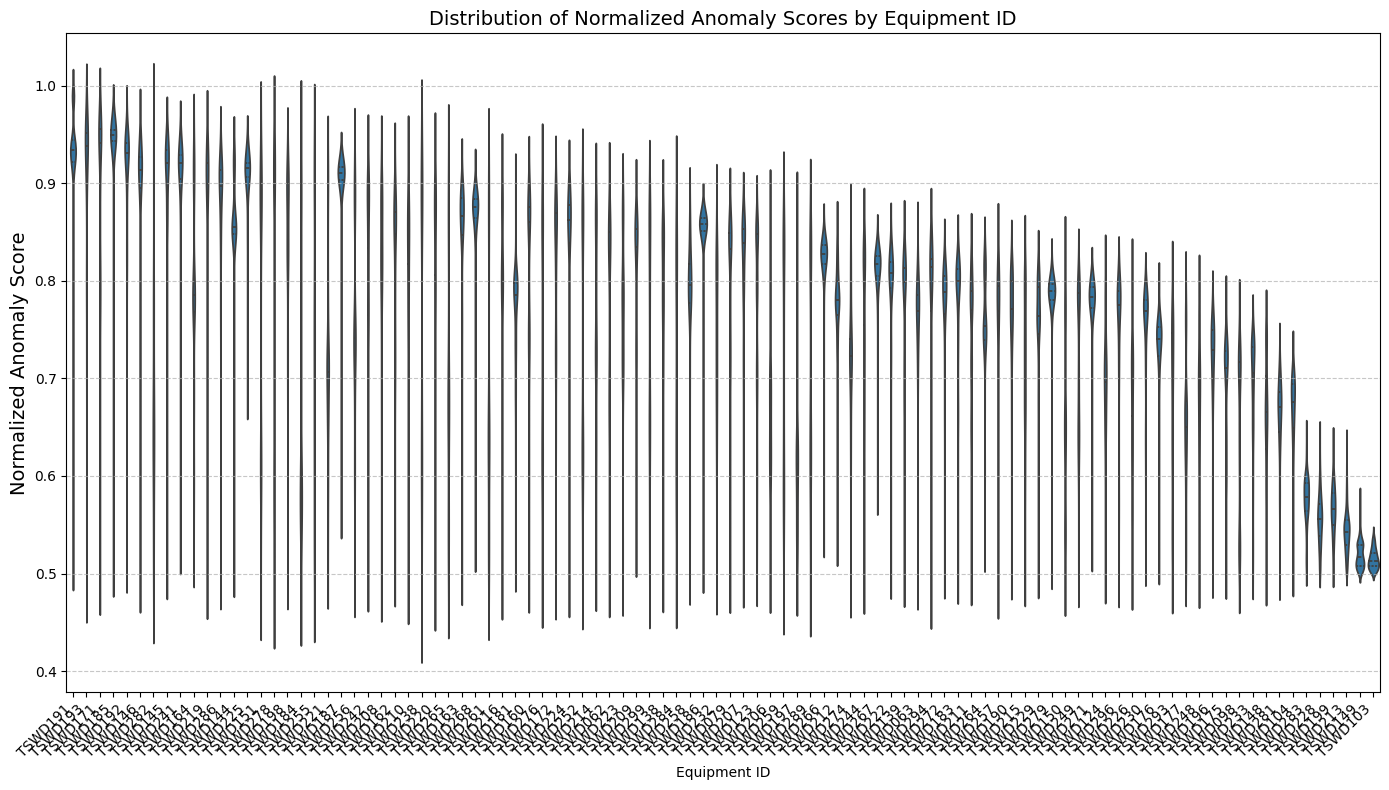

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style and size
plt.figure(figsize=(14, 8))

# Create violin plot (shows distribution density)
sns.violinplot(
    x='EquipID',
    y='AnomalyScore_normalized',
    data=anomalies_df,
    inner='quartile'  # Adds quartile lines inside the violin
)

# Improve readability
plt.title('Distribution of Normalized Anomaly Scores by Equipment ID', fontsize=14)
plt.xlabel('Equipment ID', fontsize=10)
plt.ylabel('Normalized Anomaly Score', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Add gridlines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()